In [1]:
%reset
# import libraries & modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


C:\Users\dell pc\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = "C:/Users/dell pc/Downloads/open_data/house_price_iowa/train.csv"
test_data_path = "C:/Users/dell pc/Downloads/open_data/house_price_iowa/test.csv"

# read test data file using pandas
home_data = pd.read_csv(iowa_file_path)
test_data = pd.read_csv(test_data_path)

# Drop sample where the target is missing
home_data.dropna(axis=0, subset=['SalePrice'], inplace=True) # SalePrice is the target

In [4]:
# Create target object 'y'
y = home_data.SalePrice

# Create predictor 'X'
# if using certain columns for predictor:
# features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd'] 
# X = home_data[features]

# drop column with too many NaN 
col_with_many_na = [col for col in home_data.columns if home_data[col].isnull().sum() > len(home_data)*0.75]
# if using all column except target object and irrelevant column (too many NaN, object, etc):
X = home_data.drop(['Id','SalePrice'] + col_with_many_na, axis=1)#.select_dtypes(exclude=['object'])
X_test = test_data.drop(['Id'] + col_with_many_na, axis=1)#.select_dtypes(exclude=['object'])

In [5]:
# One-hot encoding for categorical data
# "cardinality" means the number of unique values in a column.
# We use it as our only way to select categorical columns here.
# One-hot encoding generally doesn't work well with categorical variable value >15
low_cardinality_cols = [cname for cname in X.columns if 
                                X[cname].nunique() < 10 and 
                                X[cname].dtype == "object"]
numeric_cols = [cname for cname in X.columns if
                                X[cname].dtype in ['int64', 'float64']]
                
my_cols = low_cardinality_cols + numeric_cols
X_for_ohe = X[my_cols]
X_test_for_ohe = X_test[my_cols]

# One-hot encoding 'ohe'
X_ohe = pd.get_dummies(X_for_ohe)
X_test_ohe = pd.get_dummies(X_test_for_ohe)


final_X_ohe, final_X_test_ohe = X_ohe.align(X_test_ohe,
                                                join='left', 
                                                axis=1)

[3 2 3 ... 4 2 2]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD84B3A630>]],
      dtype=object)

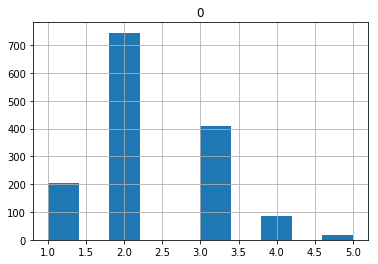

In [6]:
# Set number of bin for the most important variable for splitting train and test dataset
bins     = np.linspace(300, 3000, 5)
GrLivArea_binned = np.digitize(final_X_ohe.GrLivArea, bins)

print(GrLivArea_binned)
pd.DataFrame(GrLivArea_binned).hist()

In [7]:
# split data X into train and validation data
X_train, X_val, y_train, y_val = train_test_split(final_X_ohe, 
                                                    y,
                                                    test_size = 0.3,
                                                    stratify=GrLivArea_binned,
                                                    random_state=1)

# to do list:
# take out outlie sample
# make attribute plots

# Create Function to Measure Quality of An Approach
def score_dataset(X_train, X_val, y_train, y_val):
    model = XGBRegressor(n_estimators=1000, random_state=1)
    model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)], verbose=False)
    preds = model.predict(X_val)
    return mean_absolute_error(y_val, preds)

# average value of predicted columns
avg_y_val = y_val.sum()/len(y_val)

In [9]:
# Get Score from Imputation with Extra Columns Showing What Was Imputed
imputed_X_train_plus = X_train.copy()
imputed_X_val_plus = X_val.copy()
imputed_X_plus = final_X_test_ohe.copy()
imputed_X_valntrain_full = final_X_ohe.copy()

cols_with_missing = [col for col in X_train.columns 
                                 if X_train[col].isnull().any()]
for col in cols_with_missing:
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull()
    imputed_X_val_plus[col + '_was_missing'] = imputed_X_val_plus[col].isnull()
    imputed_X_plus[col + '_was_missing'] = imputed_X_plus[col].isnull()
    imputed_X_valntrain_full[col + '_was_missing'] = imputed_X_valntrain_full[col].isnull()

In [10]:
#  Apply Imputation, fill missing values
my_imputer = Imputer()
imputed_X_train_plus = my_imputer.fit_transform(imputed_X_train_plus)
imputed_X_val_plus = my_imputer.transform(imputed_X_val_plus)
imputed_X_plus = my_imputer.transform(imputed_X_plus)
imputed_X_valntrain_full = my_imputer.transform(imputed_X_valntrain_full)

print("Average value of predicted colums: {:,.0f}".format(avg_y_val))
mea_impute_tracker = score_dataset(imputed_X_train_plus, imputed_X_val_plus, y_train, y_val)
print("Mean Absolute Error from Imputation while Track What Was Imputed: ", mea_impute_tracker)
print("Error percentage :{:,.3%}".format(mea_impute_tracker/avg_y_val))

Average value of predicted colums: 180,768
Mean Absolute Error from Imputation while Track What Was Imputed:  15096.313347246005
Error percentage :8.351%


In [11]:
# XGBoost model
# set n_estimator for how many cycle prediction, too low-too high = under-overfit
xgb_model = XGBRegressor(n_estimators=1000, random_state=1) #option: learning_rate=0.05
# Add silent=True to avoid printing out updates with each cycle

# set early_stopping_round for how many deteriorating validation before stopping the cycle
# (automatically choose appropriate number of trees)
xgb_model.fit(imputed_X_train_plus, y_train, early_stopping_rounds=5, 
             eval_set=[(imputed_X_val_plus, y_val)], verbose=False)

# Make validation predictions and calculate mean absolute error
xgb_val_predictions = xgb_model.predict(imputed_X_val_plus)
xgb_val_mae = mean_absolute_error(xgb_val_predictions, y_val)

print("Average value of predicted column: {:,.0f}".format(avg_y_val))
print("Validation MAE for XGBoost model: {:,.0f}".format(xgb_val_mae))
print("Error percentage :{:,.3%}".format(xgb_val_mae/avg_y_val))


Average value of predicted column: 180,768
Validation MAE for XGBoost model: 15,096
Error percentage :8.351%


In [12]:
# Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=1)

gb_model.fit(imputed_X_train_plus, y_train)

# Make validation predictions and calculate mean absolute error
gb_val_predictions = gb_model.predict(imputed_X_val_plus)
gb_val_mae = mean_absolute_error(gb_val_predictions, y_val)

print("Average value of predicted column: {:,.0f}".format(avg_y_val))
print("Validation MAE for base graduent boosting model: {:,.0f}".format(gb_val_mae))
print("Error percentage :{:,.3%}".format(gb_val_mae/avg_y_val))

Average value of predicted column: 180,768
Validation MAE for base graduent boosting model: 15,486
Error percentage :8.567%


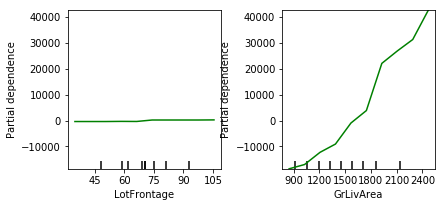

In [13]:
# partial dependence plot: look how certain feature affect the house price
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

pdplots = plot_partial_dependence(gb_model,       
                                   features=[list(X_train.columns).index('LotFrontage'),
                                             list(X_train.columns).index('GrLivArea')], # column numbers of plots we want to show
                                   X=imputed_X_train_plus,        # raw predictors data.
                                   feature_names=list(X_train.columns), # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

In [14]:
# Pipelines
# input for pipelines is pre-processed dataset just prior to imputation. So don't apply imputation before running this.
thepipe = make_pipeline(Imputer(), XGBRegressor(n_estimators=1000, random_state=1))

thepipe.fit(imputed_X_train_plus, y_train)
thepipe_pred = thepipe.predict(imputed_X_val_plus)

# Make validation predictions and calculate mean absolute error
thepipe_val_mae = mean_absolute_error(thepipe_pred, y_val)

print("Average value of predicted column: {:,.0f}".format(avg_y_val))
print("Validation MAE for base xgb model using pipeline: {:,.0f}".format(thepipe_val_mae))
print("Error percentage :{:,.3%}".format(thepipe_val_mae/avg_y_val))

Average value of predicted column: 180,768
Validation MAE for base xgb model using pipeline: 14,454
Error percentage :7.996%


In [15]:
# Cross-validation
#  just as the 'pipelines' cell,
# input for pipelines is pre-processed dataset just prior to imputation. So don't apply imputation before running this.
scores_crossval = cross_val_score(thepipe, imputed_X_valntrain_full, y, scoring='neg_mean_absolute_error') # option: scoring='accuracy'
print(scores_crossval)
print('Mean Absolute Error %2f' %(-1 * scores_crossval.mean()))


[-14811.30036416 -16734.51183907 -16290.52047164]
Mean Absolute Error 15945.444225


In [16]:
# Creating model and output for Kaggle competition
# To improve accuracy, create a new Random Forest model to train on all training data
xgb_model_on_full_data = XGBRegressor(n_estimators=1000, random_state=1)

# fit rf_model_on_full_data on all data from the 
xgb_model_on_full_data.fit(imputed_X_valntrain_full, y, verbose=False)

# make predictions which we will submit. 
test_preds = xgb_model_on_full_data.predict(imputed_X_plus)

# The lines below shows how to save your data in the format needed to store it in the competition
output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})

output.to_csv("C:/Users/dell pc/Downloads/open_data/house_price_iowa/submission.csv", index=False)

print("Done")

Done
